## TOC:
* [Read in and clean data](#read_data)
* [Data preprocessing & preparation](#data_prep)
    * [Identify & pad punctuations](#pad_punc)
    * [Tokenize text data](#tokenize)
* [Build RNN model](#build_rnn)
    * [Model with Bidirectional SimpleRNN (16) > Dense (64 units & relu) > Dropout (0.5) > Dense (1)](#rnn1)
        * [Plots of training & validation accuracy & loss](#rnn1_plots)
        * [Evaluate on test set](#rnn1_eval)
    * [Model with SimpleRNN (16) > Dense (64 units & relu) > Dropout (0.5) > Dense (1)](#rnn2)
    * [Model with SimpleRNN (16) > Dropout (0.5) > Dense (1)](#rnn3)
        * [Hyperparameter tuning](#rnn3_hp)

In [1]:
# import packages
import os
import re
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import keras_tuner
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import math

# Read in and clean data <a class="anchor" id="read_data"></a>
- drop duplicates
- remove publisher info
- train-test split

In [2]:
fake_news = pd.read_csv("Fake.csv")
real_news = pd.read_csv("True.csv")

fake_news['fake'] = 1
real_news['fake'] = 0
news = pd.concat([fake_news, real_news])
news.reset_index(inplace=True, drop=True)

news['all_text'] = news['title'] + ' '+ news['text'] 
news.drop_duplicates(subset=['all_text'], inplace = True)

news['text'] = news['text'].map(lambda x: re.sub(r'^.+ \(Reuters\) - ','',x))
news['all_text'] = news['title'] + ' ' + news['text'] 

#features = news.loc[:, ~news.columns.isin(['fake'])]
features = news['title']
target = news['fake']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

# Data preprocessing & preparation <a class="anchor" id="data_prep"></a>

### Identify & pad punctuations <a class="anchor" id="pad_punc"></a>

In [3]:
def getPunctuations(text_col):
    '''
    Parameters
    ----------
    text_col : Series of strings
    
    Returns
    -------
    punctuations : string of all non-alphanumeric & non-space characters
    '''
    regx = re.compile(r'[\W_]')
    res = []
    for i in text_col:
        res.extend(regx.findall(i))
    res = set(res)
    spaces = ['\u200a', '\u200b', '\u200f', '\u202a', '\u200e', '\xa0', '\u202c', '\ufeff', '\n', '\r', '\t', ' ']
    for s in spaces:
        res.remove(s)
    
    punctuations = ''
    for r in res:
        punctuations += r
        
    return punctuations

# pad punctuations with spaces to allow tokenizer to correctly identify words
def padPunctuation(data):
    res = []
    for i in data:
        x = i.translate(str.maketrans({key: " {0} ".format(key) for key in punctuations})) # account for punctuations used in certain text not included in string.punctuation
        res.append(x)
    return res

In [4]:
punctuations = getPunctuations(news['all_text'])
X_train = padPunctuation(X_train)
X_test = padPunctuation(X_test)

### Tokenize text data <a class="anchor" id="tokenize"></a>

In [5]:
tokenizer = Tokenizer(filters='\t\n',
                      lower=False)
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: {}".format(vocab_size))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# get length of longest title and pad all shorter titles to match length
max_len = max([len(x) for x in X_train] + [len(x) for x in X_test])
print("Max Title Length: {}".format(max_len))
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=max_len)

Vocab Size: 29542
Max Title Length: 56


# Build RNN model <a class="anchor" id="build_rnn"></a>

## Model with Bidirectional SimpleRNN (16) > Dense (64 units & relu) > Dropout (0.5) > Dense (1) <a class="anchor" id="rnn1"></a>

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, math.ceil(vocab_size**0.25), input_length=max_len), # https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html
    #tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 56, 14)            413588    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               992       
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 416,757
Trainable params: 416,757
Non-trainable params: 0
__________________________________________________

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_split=0.1, batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
880/880 [==============================] - 148s 165ms/step - loss: 0.2773 - accuracy: 0.8633 - val_loss: 0.0510 - val_accuracy: 0.9857
Epoch 2/10
880/880 [==============================] - 150s 170ms/step - loss: 0.0349 - accuracy: 0.9924 - val_loss: 0.0168 - val_accuracy: 0.9942
Epoch 3/10
880/880 [==============================] - 137s 155ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 0.0128 - val_accuracy: 0.9945
Epoch 4/10
880/880 [==============================] - 145s 164ms/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 0.0200 - val_accuracy: 0.9945
Epoch 5/10
880/880 [==============================] - 147s 167ms/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.0140 - val_accuracy: 0.9962


### Plots of training & validation accuracy & loss <a class="anchor" id="rnn1_plots"></a>

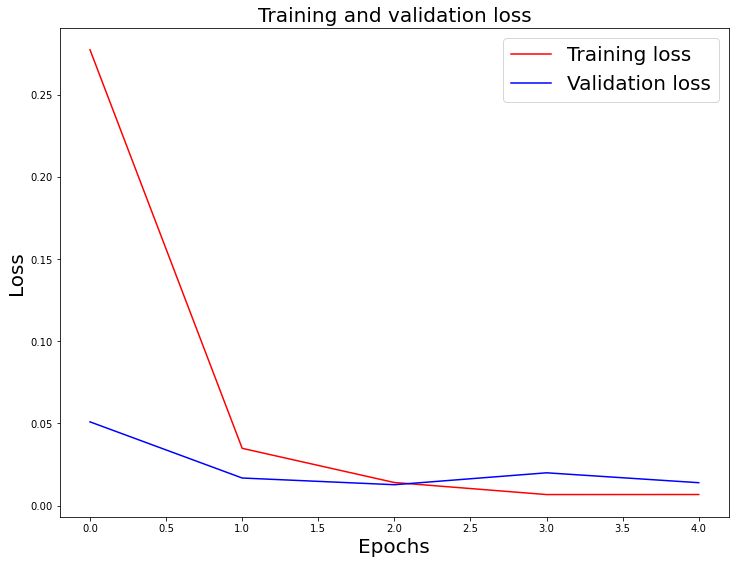

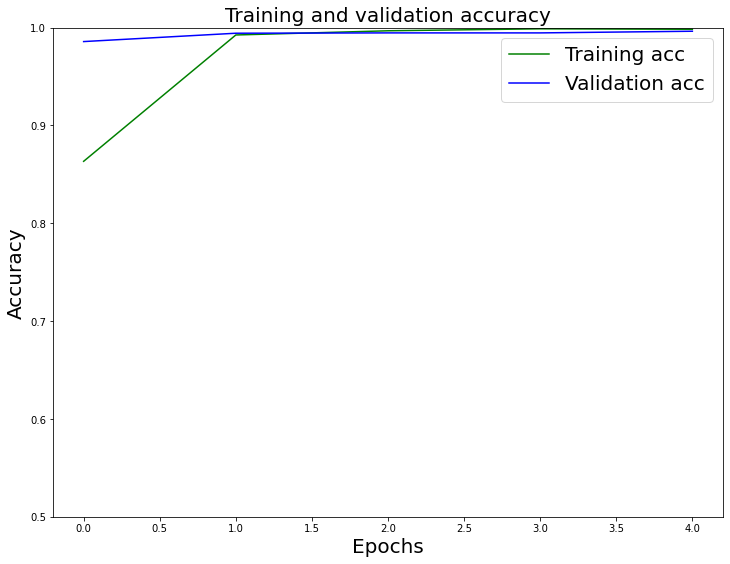

In [8]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

### Evaluate on test set <a class="anchor" id="rnn1_eval"></a>

In [9]:
model.evaluate(X_test, y_test)

306/306 [==============================] - 8s 25ms/step - loss: 0.0141 - accuracy: 0.9954


[0.014117153361439705, 0.9953973889350891]

## Model with SimpleRNN (16) > Dense (64 units & relu) > Dropout (0.5) > Dense (1) <a class="anchor" id="rnn2"></a>

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, math.ceil(vocab_size**0.25), input_length=max_len), # https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html
    tf.keras.layers.SimpleRNN(16),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_split=0.1, batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
880/880 [==============================] - 71s 78ms/step - loss: 0.4295 - accuracy: 0.7611 - val_loss: 0.1298 - val_accuracy: 0.9611
Epoch 2/10
880/880 [==============================] - 73s 82ms/step - loss: 0.0809 - accuracy: 0.9801 - val_loss: 0.0777 - val_accuracy: 0.9812
Epoch 3/10
880/880 [==============================] - 74s 84ms/step - loss: 0.0354 - accuracy: 0.9912 - val_loss: 0.0670 - val_accuracy: 0.9836
Epoch 4/10
880/880 [==============================] - 74s 84ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 0.0642 - val_accuracy: 0.9857
Epoch 5/10
880/880 [==============================] - 76s 87ms/step - loss: 0.0096 - accuracy: 0.9978 - val_loss: 0.0631 - val_accuracy: 0.9857
Epoch 6/10
880/880 [==============================] - 76s 86ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0613 - val_accuracy: 0.9877
Epoch 7/10
880/880 [==============================] - 76s 87ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0675 - val_accuracy:

In [7]:
model.evaluate(X_test, y_test)

306/306 [==============================] - 4s 12ms/step - loss: 0.0486 - accuracy: 0.9884


[0.04862477630376816, 0.9884422421455383]

## Model with SimpleRNN (16) > Dropout (0.5) > Dense (1) <a class="anchor" id="rnn3"></a>

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, math.ceil(vocab_size**0.25), input_length=max_len), # https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html
    tf.keras.layers.SimpleRNN(16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_split=0.1, batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
880/880 [==============================] - 74s 83ms/step - loss: 0.3899 - accuracy: 0.8424 - val_loss: 0.2170 - val_accuracy: 0.9662
Epoch 2/10
880/880 [==============================] - 73s 83ms/step - loss: 0.2078 - accuracy: 0.9625 - val_loss: 0.1697 - val_accuracy: 0.9666
Epoch 3/10
880/880 [==============================] - 75s 85ms/step - loss: 0.1521 - accuracy: 0.9763 - val_loss: 0.1187 - val_accuracy: 0.9795
Epoch 4/10
880/880 [==============================] - 70s 80ms/step - loss: 0.1692 - accuracy: 0.9668 - val_loss: 0.1005 - val_accuracy: 0.9826
Epoch 5/10
880/880 [==============================] - 70s 80ms/step - loss: 0.1058 - accuracy: 0.9851 - val_loss: 0.0868 - val_accuracy: 0.9836
Epoch 6/10
880/880 [==============================] - 70s 80ms/step - loss: 0.0892 - accuracy: 0.9874 - val_loss: 0.0873 - val_accuracy: 0.9830
Epoch 7/10
880/880 [==============================] - 71s 80ms/step - loss: 0.0951 - accuracy: 0.9849 - val_loss: 0.0745 - val_accuracy:

In [9]:
model.evaluate(X_test, y_test)

306/306 [==============================] - 4s 11ms/step - loss: 0.0789 - accuracy: 0.9849


[0.07885951548814774, 0.9848624467849731]

### Hyperparameter tuning <a class="anchor" id="rnn3_hp"></a>

In [25]:
#https://www.tensorflow.org/tutorials/keras/keras_tuner
def hyperparameterTuning(hp): #https://keras.io/api/keras_tuner/hyperparameters/
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, 
                                  output_dim=hp.Int('output_dim', min_value=6, max_value=30, step=4), 
                                  input_length=max_len), #https://keras.io/api/layers/core_layers/embedding/
        tf.keras.layers.SimpleRNN(units=hp.Int('units', min_value=16, max_value=64, step=16)), #https://keras.io/api/layers/recurrent_layers/simple_rnn/
        tf.keras.layers.Dropout(rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.1)), #https://keras.io/api/layers/regularization_layers/dropout/
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    return model

In [28]:
tuner = keras_tuner.Hyperband(hyperparameterTuning,
                              objective='val_loss')

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss')
tuner.search(X_train, y_train, epochs=10,
             validation_split=0.1,
             shuffle=True, callbacks=[early_stop])

Trial 160 Complete [00h 04m 41s]
val_loss: 0.14531034231185913

Best val_loss So Far: 0.006980834994465113
Total elapsed time: 07h 55m 58s
INFO:tensorflow:Oracle triggered exit


In [35]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
output_dim: 10
units: 64
rate: 0.5
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0138
Score: 0.006980834994465113
Trial summary
Hyperparameters:
output_dim: 30
units: 64
rate: 0.30000000000000004
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 4
tuner/round: 2
tuner/trial_id: 0109
Score: 0.013989675790071487
Trial summary
Hyperparameters:
output_dim: 14
units: 64
rate: 0.1
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.015184544026851654
Trial summary
Hyperparameters:
output_dim: 10
units: 64
rate: 0.5
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 4
tuner/round: 2
tuner/trial_id: 0107
Score: 0.016141895204782486
Trial summary
Hyperparameters:
output_dim: 14
units: 64
rate: 0.1
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 4
tuner/round: 2
tuner/trial_id: 0099
Score

In [39]:
#https://www.tensorflow.org/tutorials/keras/keras_tuner
def hyperparameterTuning2(hp): #https://keras.io/api/keras_tuner/hyperparameters/
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, 
                                  output_dim=hp.Int('output_dim', min_value=10, max_value=30, step=10), 
                                  input_length=max_len), #https://keras.io/api/layers/core_layers/embedding/
        tf.keras.layers.SimpleRNN(units=hp.Int('units', min_value=32, max_value=96, step=32)), #https://keras.io/api/layers/recurrent_layers/simple_rnn/
        tf.keras.layers.Dropout(rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.2)), #https://keras.io/api/layers/regularization_layers/dropout/
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    return model

tuner2 = keras_tuner.Hyperband(hyperparameterTuning2,
                              objective='val_loss',
                              directory='tuner2')
tuner2.search(X_train, y_train, epochs=10,
             validation_split=0.1,
             shuffle=True, callbacks=[early_stop])

Trial 26 Complete [00h 02m 20s]
val_loss: 0.052951544523239136

Best val_loss So Far: 0.018749158829450607
Total elapsed time: 01h 00m 54s
INFO:tensorflow:Oracle triggered exit


In [40]:
tuner2.results_summary()

Results summary
Results in tuner2\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
output_dim: 30
units: 96
rate: 0.5000000000000001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.018749158829450607
Trial summary
Hyperparameters:
output_dim: 20
units: 96
rate: 0.30000000000000004
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.02514771558344364
Trial summary
Hyperparameters:
output_dim: 30
units: 96
rate: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.025511175394058228
Trial summary
Hyperparameters:
output_dim: 20
units: 64
rate: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.02601861208677292
Trial summary
Hyperparameters:
output_dim: 30
units: 64
rate: 0.5000000000000001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.026034077629446983
Trial summary
Hyperparameters:
output_dim: 10
units: 96
r